In [2]:
#import module
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Lambda
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K
from keras import metrics

from matplotlib import pyplot as plt
import numpy as np

Using TensorFlow backend.


In [3]:
# layer define
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

#loss define
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

def normalized(x):
    x -= x.min()
    x /= x.max()
    return x


In [4]:
#data load
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = train_x / 255
test_x = test_x / 255
train_x = train_x.reshape((train_x.shape[0], -1))
test_x = test_x.reshape((test_x.shape[0], -1))

In [20]:
#model construct
#嘗試把encode和decode層加深
x = Input(shape=(784,))

#enc_0 = Dense(256, activation='relu')
enc_1 = Dense(128, activation='relu')
enc_2 = Dense(64, activation='relu')
enc_3 = Dense(32, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

enc_x = enc_3(enc_2(enc_1(x)))
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

dec_4 = Dense(32, activation='sigmoid')
dec_3 = Dense(64, activation='relu')
dec_2 = Dense(100, activation='relu')
#dec_1 = Dense(256, activation='relu')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(dec_3(dec_4(z))))

VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          100480      input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           8256        dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           2080        dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (

In [21]:
#model compile and train
VAE.compile(loss=vae_loss, optimizer='adam')
#VAE.fit(train_x, train_x, batch_size=32, epochs=100) 
VAE.load_weights('vae_weight_b.h5')

In [25]:
#model evaluation
VAE.evaluate(test_x, test_x)

10000/10000 [==============================] - 1s 98us/step

143.48269550781251

In [22]:
#encoder and decoder
h_input = Input(shape=(2, ))

VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()
VAE_Decoder = Model(h_input, dec_1(dec_2(dec_3(dec_4(h_input)))))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 110,882
Trainable params: 110,882
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu

第 31431 圖的 latent 表示為 [[-0.87536985 -0.37351233]]


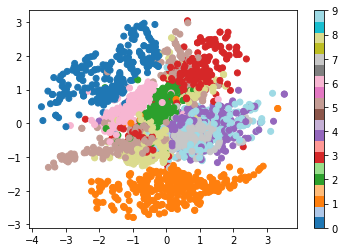

In [28]:
#visualize encoder result
idx = np.random.randint(train_x.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(train_x[idx: idx+1])))
indices = np.random.randint(test_x.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(test_x[indices])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=test_y[indices], cmap='tab20')
plt.colorbar()
plt.show()

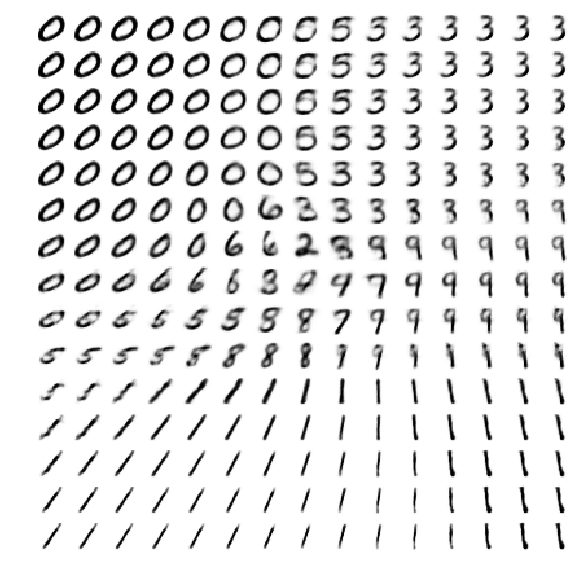

In [31]:
#visualize decoder
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()



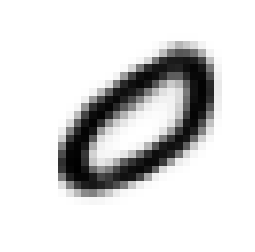

In [32]:
#interacting visualization
from ipywidgets import interact, FloatSlider, IntSlider

digit_size = 28
def num_plot(x, y):
    VAE_figure = np.zeros((digit_size, digit_size))
    z_sample = np.array([[x, y]])
    x_decoded = VAE_Decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    VAE_figure = normalized(digit)
    plt.figure()
    plt.imshow(VAE_figure, cmap='Greys')
    plt.axis('off')
    plt.show()

interact(num_plot, x=FloatSlider(value=0, min=-4.0, max=4.0,step=0.2), y=FloatSlider(value=0, min=-4.0, max=4.0,step=0.2))